#### Classification | Model

# Predicting Heart Disease  

#TOC

### Classification Model Stepwise Analysis <a id='top'></a>

1. [Research Question](#1)<br/>
2. [DataFrames](#2) <br/>
3. [Exploratory Data Analysis](#3)<br/>
   [Data Summary](#31)<br/>
   [Classification Viability](#32)<br/>
   [Classification Metrics](#33)<br/>
4. [Baseline](#4)<br/>
5. [Validation](#5)<br/>
6. [Model Iterations](#6) <br/>
    1 [Dummy Classifier](#61)<br/>
    2 [Logistic Regression](#62)<br/>
    3 [Decision Trees: Depth 2](#63)<br/>
    4 [Decision Trees: Depth 4](#64)<br/>
    5 [Random Forests](#65)<br/>
    6 [Gradient Boosted Trees: xgboost](#66)<br/>
    7 [Naive Bayes: Bernoulli](#67)<br/>
    8 [Naive Bayes: Gaussian](#68)<br/>
    9 [Naive Bayes: Multinomial](#69)<br/>
    10 [Ensemble:  Naive Bayes Hard Voting Classifier](#610)<br/>
    11 [Ensemble:  Naive Bayes Soft Voting Classifier](#611)<br/>
    12 [Ensemble:  Stacking Classifier (non-NBs)](#612)<br/>
    [Feature Engineering](#fe)<br/>
    13 [Logistic regression: Question groups](#613)<br/>
    14 [Logistic regression: Risk factors](#614)<br/>
    15 [Logistic regression: Question groups + Risk factor features](#615)<br/>
    [Class Imbalance Handling](#cih)<br/>
    16 [Logistic regression: threshold = 0.05](#616)<br/>
    [Model Tuning: GridSearchCV](#gscv)<br/>
    17 [Logistic regression: GridSearchCV](#617)<br/>
    18 [Logistic regression: GridSearchCV + threshold = 0.05](#618)<br/>
7. [Model: Predicting Heart Disease ](#7)<br/>
    [Test Model](#71)<br/>
    [Confusion Matrix](#72)<br/>
    [ROC AUC (X, y)](#73) <br/>
    [Feature Correlations](#74) <br/>
    [Predictions](#75)


# √ import code

In [5]:
import pandas as pd
import numpy as np
import imblearn.over_sampling
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import sklearn
# import dataframe_image as dfi
import pickle
import warnings
warnings.filterwarnings("ignore")
# import plotly.express as px
# import plotly.graph_objects as go

plt.style.use('ggplot')
%matplotlib inline
sns.set_style("whitegrid")

np.set_printoptions(suppress=True)

from sklearn.ensemble import StackingClassifier
from plotly.subplots import make_subplots
from sklearn import tree
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

# **1 | Research Design**



* **Research Question:** What model can best predict patients' risk for heart disease?
* **Impact Hypothesis:** Reduce the number of patients who develop heart disease (arterial plaque or heart attack).
* **Data source:** [Personal Key Indicators of Heart Disease](https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease), n=319,795
* **Error metric:** [Recall](#3c) and [ROC AUC](#3c)

#### [Data Dictionary](https://www.cdc.gov/brfss/annual_data/2020/pdf/codebook20_llcp-v2-508.pdf)<a id='1a'></a>


_Target_
- `y_heart_disease`: Y/N | coronary heart disease (CHD) or myocardial infarction (MI)

_Health Behaviors_
- `behavior_activity`: Num (0-30) | # days did physical activity/ exercise other than regular job
- `behavior_alcohol`: Y/N | heavy drinker, defined as men: 14+/wk, women: 7+/wk (includes beer, wine, malt beverage, liquor)
- `behavior_sleep`: Num (0-24) | # hours of sleep in a 24-hour period, on average
- `behavior_tobacco`: Y/N | smoked at least 100 cigarettes in your life

_Demographics_
- `demg_age`: 18-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54, 55-59, 60-64, 65-69, 70-74, 75-79, 80+
- `demg_gender`: male/female
- `demg_race`: White, Black, Asian, American Indian/Alaskan Native, Hispanic, Other race

_Health Measures_
- `health_bmi`: Num | Body Mass Index (BMI)
- `health_physical`: Num (0-30) | # days physical health  not good, includes physical illness and injury
- `health_mental`: Num (0-30 ) | # days mental health not good, includes stress, depression, and problems with emotions
- `health_general`: Excellent, Very Good, Fair, Poor | Would you say that in general your health is...
- `health_mobility`: Y/N | serious difficulty walking or climbing stairs

_Chronic Disease_
- `disease_asthma`: Y/N
- `disease_diabetes`: Y/N/Y pregnancy/N borderline
- `disease_kidney`: Y/N | kidney disease, excludes kidney stones, bladder infection or incontinence
- `disease_skin`: Y/N | skin cancer
- `disease_stroke`: Y/N

[back to top](#top)

# **2 | [DataFrames](https://github.com/slp22/classification-project/blob/main/classification-heart-disease_mvp.ipynb)**

#### `heart_2020_cleaned_df`

In [ ]:
heart_2020_cleaned_df = pd.read_csv('/heart_2020_cleaned.csv')
heart_2020_cleaned_df.describe().T.style.background_gradient(cmap='Blues')

,count,mean,std,min,25%,50%,75%,max
BMI,319795.000000,28.325399,6.356100,12.020000,24.030000,27.340000,31.420000,94.850000
PhysicalHealth,319795.000000,3.371710,7.950850,0.000000,0.000000,0.000000,2.000000,30.000000
MentalHealth,319795.000000,3.898366,7.955235,0.000000,0.000000,0.000000,3.000000,30.000000
SleepTime,319795.000000,7.097075,1.436007,1.000000,6.000000,7.000000,8.000000,24.000000




*   [BMI](https://www.nhlbi.nih.gov/health/educational/lose_wt/BMI/bmi_tbl2.htm) range is 19-54
*   BMI max in `heart_2020_cleaned_df` is 94.85



In [ ]:
heart_2020_cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

#### `heart_disease_df`

In [ ]:
heart_disease_df = pd.read_csv('/heart_disease_df.csv')
heart_disease_df.head(3)

,behavior_activity,behavior_alcohol,behavior_sleep,behavior_tobacco,demg_age,demg_gender,demg_race,disease_asthma,disease_diabetes,disease_kidney,disease_skin,disease_stroke,health_bmi,health_general,health_mental,health_mobility,health_physical,y_heart_disease
0,Yes,No,5.0,Yes,55-59,Female,White,Yes,Yes,No,Yes,No,16.60,Very good,30.0,No,3.0,No
1,Yes,No,7.0,No,80 or older,Female,White,No,No,No,No,Yes,20.34,Very good,0.0,No,0.0,No
2,Yes,No,8.0,Yes,65-69,Male,White,Yes,Yes,No,No,No,26.58,Fair,30.0,No,20.0,No


In [ ]:
heart_disease_df.describe().T.style.background_gradient(cmap='Blues')

,count,mean,std,min,25%,50%,75%,max
behavior_sleep,319795.000000,7.097075,1.436007,1.000000,6.000000,7.000000,8.000000,24.000000
health_bmi,319795.000000,28.325399,6.356100,12.020000,24.030000,27.340000,31.420000,94.850000
health_mental,319795.000000,3.898366,7.955235,0.000000,0.000000,0.000000,3.000000,30.000000
health_physical,319795.000000,3.371710,7.950850,0.000000,0.000000,0.000000,2.000000,30.000000


#### `heart_disease_df_dmy`

In [ ]:
heart_disease_df_dmy = pd.read_csv('/heart_disease_df_dmy.csv')
heart_disease_df_dmy.describe().T.style.background_gradient(cmap='Blues')

,count,mean,std,min,25%,50%,75%,max
behavior_sleep,319795.000000,7.097075,1.436007,1.000000,6.000000,7.000000,8.000000,24.000000
health_bmi,319795.000000,28.325399,6.356100,12.020000,24.030000,27.340000,31.420000,94.850000
health_mental,319795.000000,3.898366,7.955235,0.000000,0.000000,0.000000,3.000000,30.000000
health_physical,319795.000000,3.371710,7.950850,0.000000,0.000000,0.000000,2.000000,30.000000
behavior_activity_Yes,319795.000000,0.775362,0.417344,0.000000,1.000000,1.000000,1.000000,1.000000
behavior_alcohol_Yes,319795.000000,0.068097,0.251912,0.000000,0.000000,0.000000,0.000000,1.000000
behavior_tobacco_Yes,319795.000000,0.412477,0.492281,0.000000,0.000000,0.000000,1.000000,1.000000
demg_age_25-29,319795.000000,0.053018,0.224070,0.000000,0.000000,0.000000,0.000000,1.000000
demg_age_30-34,319795.000000,0.058641,0.234951,0.000000,0.000000,0.000000,0.000000,1.000000
demg_age_35-39,319795.000000,0.064260,0.245216,0.000000,0.000000,0.000000,0.000000,1.000000


[back to top](#top)

#### √ `heart_disease_df_map`

From [MVP EDA](https://github.com/slp22/classification-project/blob/main/classification-heart-disease_mvp.ipynb) map Y/N to 1/0:
* behavior_activity ['Yes' 'No']
* behavior_alcohol ['No' 'Yes']
* behavior_tobacco ['Yes' 'No']
* disease_asthma ['Yes' 'No']
* disease_diabetes ['Yes' 'No' 'No, borderline diabetes' 'Yes (during pregnancy)'] #adjust in next cell
* disease_kidney ['No' 'Yes']
* disease_skin ['Yes' 'No']
* disease_stroke ['No' 'Yes']
* health_mobility ['No' 'Yes']
* y_heart_disease ['No' 'Yes']

`df_map = df_map.replace({'Yes': 1, 'No': 0})`

In [7]:
# load df from EDA for MVP
heart_disease_df_map = pd.read_csv('/content/heart_disease_df_map.csv')

# transformed df: mapped categorical variables to numerical values
heart_disease_df_map.head(3)

,behavior_activity,behavior_alcohol,behavior_sleep,behavior_tobacco,demg_age,demg_gender,demg_race,disease_asthma,disease_diabetes,disease_kidney,disease_skin,disease_stroke,health_bmi,health_general,health_mental,health_mobility,health_physical,y_heart_disease
0,1,0,5.0,1,55,1,6,1,1,0,1,0,16.60,4,30.0,0,3.0,0
1,1,0,7.0,0,80,1,6,0,0,0,0,1,20.34,4,0.0,0,0.0,0
2,1,0,8.0,1,65,2,6,1,1,0,0,0,26.58,2,30.0,0,20.0,0


# **3 | Exploratory Data Analysis**

*   Using `heart_disease_df_map` with mapped variables for modeling. (Full EDA part of [MVP](https://github.com/slp22/classification-project/blob/main/classification-heart-disease_mvp.ipynb).)



### 3.1 Data Summary<a id='31'></a>

In [ ]:
# dataframe info
heart_disease_df_map.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   behavior_activity  319795 non-null  int64  
 1   behavior_alcohol   319795 non-null  int64  
 2   behavior_sleep     319795 non-null  float64
 3   behavior_tobacco   319795 non-null  int64  
 4   demg_age           319795 non-null  int64  
 5   demg_gender        319795 non-null  int64  
 6   demg_race          319795 non-null  int64  
 7   disease_asthma     319795 non-null  int64  
 8   disease_diabetes   319795 non-null  int64  
 9   disease_kidney     319795 non-null  int64  
 10  disease_skin       319795 non-null  int64  
 11  disease_stroke     319795 non-null  int64  
 12  health_bmi         319795 non-null  float64
 13  health_general     319795 non-null  int64  
 14  health_mental      319795 non-null  float64
 15  health_mobility    319795 non-null  int64  
 16  he

*   No missing values
*   All data types are numerical.

In [ ]:
# # shift column 'C' to first position
# first_column = heart_disease_df_map.pop('y_heart_disease')

# # #insert column using insert(position,column_name,first_column) function
# heart_disease_df_map.insert(0, 'y_heart_disease', first_column)

# heart_disease_df_map.head(3)

,y_heart_disease,behavior_activity,behavior_alcohol,behavior_sleep,behavior_tobacco,demg_age,demg_gender,demg_race,disease_asthma,disease_diabetes,disease_kidney,disease_skin,disease_stroke,health_bmi,health_general,health_mental,health_mobility,health_physical
0,0,1,0,5.0,1,55,1,6,1,1,0,1,0,16.60,4,30.0,0,3.0
1,0,1,0,7.0,0,80,1,6,0,0,0,0,1,20.34,4,0.0,0,0.0
2,0,1,0,8.0,1,65,2,6,1,1,0,0,0,26.58,2,30.0,0,20.0


[back to top](#top)

### 3.2 Classification Viability<a id='32'></a>

In [ ]:
# descriptive statistics
heart_disease_df_map.describe().T.style.background_gradient(cmap='Blues')

,count,mean,std,min,25%,50%,75%,max
y_heart_disease,319795.000000,0.085595,0.279766,0.000000,0.000000,0.000000,0.000000,1.000000
behavior_activity,319795.000000,0.775362,0.417344,0.000000,1.000000,1.000000,1.000000,1.000000
behavior_alcohol,319795.000000,0.068097,0.251912,0.000000,0.000000,0.000000,0.000000,1.000000
behavior_sleep,319795.000000,7.097075,1.436007,1.000000,6.000000,7.000000,8.000000,24.000000
behavior_tobacco,319795.000000,0.412477,0.492281,0.000000,0.000000,0.000000,1.000000,1.000000
demg_age,319795.000000,52.440945,18.069747,18.000000,40.000000,55.000000,65.000000,80.000000
demg_gender,319795.000000,1.475273,0.499389,1.000000,1.000000,1.000000,2.000000,2.000000
demg_race,319795.000000,5.396742,1.212208,1.000000,6.000000,6.000000,6.000000,6.000000
disease_asthma,319795.000000,0.134061,0.340718,0.000000,0.000000,0.000000,0.000000,1.000000
disease_diabetes,319795.000000,0.207205,0.554528,0.000000,0.000000,0.000000,0.000000,3.000000


#### Correlation

In [ ]:
# correlation matrix
heart_disease_df_map.corr().style.background_gradient(cmap='Blues')

,y_heart_disease,behavior_activity,behavior_alcohol,behavior_sleep,behavior_tobacco,demg_age,demg_gender,demg_race,disease_asthma,disease_diabetes,disease_kidney,disease_skin,disease_stroke,health_bmi,health_general,health_mental,health_mobility,health_physical
y_heart_disease,1.000000,-0.100030,-0.032080,0.008327,0.107764,0.232325,0.070040,0.034854,0.041444,0.118281,0.145197,0.093317,0.196835,0.051803,-0.243182,0.028591,0.201258,0.170721
behavior_activity,-0.100030,1.000000,0.017487,0.003849,-0.097174,-0.121465,0.048247,0.056767,-0.041526,-0.097539,-0.081827,-0.001328,-0.079455,-0.150616,0.281249,-0.095808,-0.278524,-0.232283
behavior_alcohol,-0.032080,0.017487,1.000000,-0.005065,0.111768,-0.058837,0.004200,0.036702,-0.002202,-0.042695,-0.028280,-0.005702,-0.019858,-0.038816,0.029780,0.051282,-0.035328,-0.017254
behavior_sleep,0.008327,0.003849,-0.005065,1.000000,-0.030336,0.103071,-0.015704,0.035889,-0.048245,-0.005166,0.006238,0.041266,0.011900,-0.051822,0.063071,-0.119717,-0.022216,-0.061387
behavior_tobacco,0.107764,-0.097174,0.111768,-0.030336,1.000000,0.130384,0.085052,0.065499,0.024149,0.038993,0.034920,0.033977,0.061226,0.023118,-0.174717,0.085157,0.120074,0.115352
demg_age,0.232325,-0.121465,-0.058837,0.103071,0.130384,1.000000,-0.067682,0.162777,-0.058235,0.154070,0.122697,0.262208,0.137280,-0.001740,-0.188236,-0.155455,0.242552,0.110789
demg_gender,0.070040,0.048247,0.004200,-0.015704,0.085052,-0.067682,1.000000,0.018855,-0.069191,-0.018350,-0.009084,0.013434,-0.003091,0.026940,0.025947,-0.100058,-0.068860,-0.040904
demg_race,0.034854,0.056767,0.036702,0.035889,0.065499,0.162777,0.018855,1.000000,-0.017975,-0.056252,0.003709,0.134780,-0.003956,-0.037424,0.057986,-0.014491,-0.015831,-0.000847
disease_asthma,0.041444,-0.041526,-0.002202,-0.048245,0.024149,-0.058235,-0.069191,-0.017975,1.000000,0.044136,0.039707,-0.000396,0.038866,0.092345,-0.137342,0.114008,0.103222,0.117907
disease_diabetes,0.118281,-0.097539,-0.042695,-0.005166,0.038993,0.154070,-0.018350,-0.056252,0.044136,1.000000,0.095186,0.024113,0.072476,0.163437,-0.204278,0.029970,0.152876,0.111644


In [ ]:
# correlation matrix subset
heart_sub_corr = heart_disease_df_map[['y_heart_disease', 'demg_age', 'behavior_tobacco',
                      'health_physical', 'health_mobility',
                      'disease_diabetes','disease_kidney','disease_stroke']].corr()
heart_sub_corr.style.background_gradient(cmap='Blues')

,y_heart_disease,demg_age,behavior_tobacco,health_physical,health_mobility,disease_diabetes,disease_kidney,disease_stroke
y_heart_disease,1.000000,0.232325,0.107764,0.170721,0.201258,0.118281,0.145197,0.196835
demg_age,0.232325,1.000000,0.130384,0.110789,0.242552,0.154070,0.122697,0.137280
behavior_tobacco,0.107764,0.130384,1.000000,0.115352,0.120074,0.038993,0.034920,0.061226
health_physical,0.170721,0.110789,0.115352,1.000000,0.428373,0.111644,0.142197,0.137014
health_mobility,0.201258,0.242552,0.120074,0.428373,1.000000,0.152876,0.153064,0.174143
disease_diabetes,0.118281,0.154070,0.038993,0.111644,0.152876,1.000000,0.095186,0.072476
disease_kidney,0.145197,0.122697,0.034920,0.142197,0.153064,0.095186,1.000000,0.091167
disease_stroke,0.196835,0.137280,0.061226,0.137014,0.174143,0.072476,0.091167,1.000000


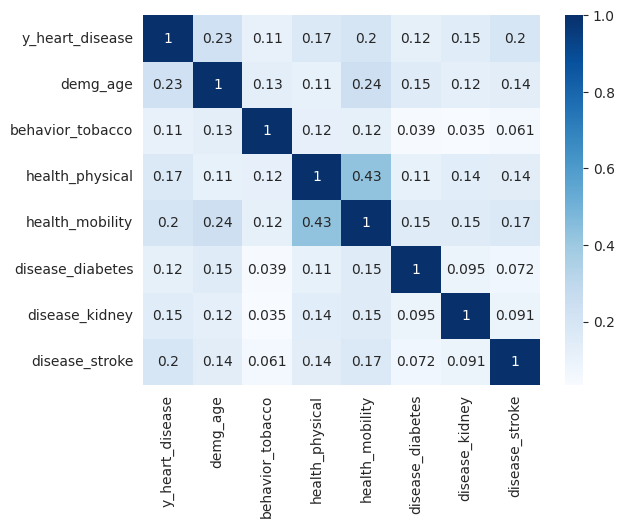

In [ ]:
sns.heatmap(heart_sub_corr, annot=True, cmap='Blues');

*   A classification model is viable.




[back to top](#top)

#### Boxplots

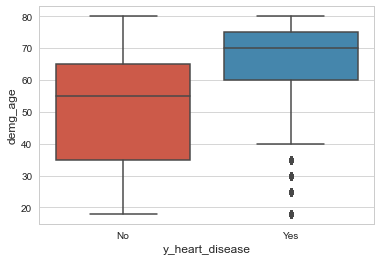

In [ ]:
# target vs age
ax = sns.boxplot(x='y_heart_disease', y='demg_age', data=heart_disease_df_map)
ax.set_xticklabels(['No', 'Yes']);


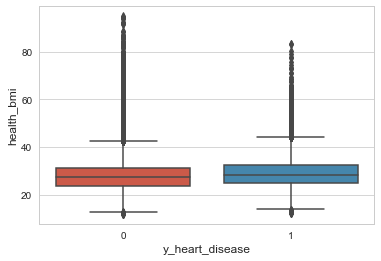

In [ ]:
# target vs mobility
sns.boxplot(x='y_heart_disease', y='health_bmi', data=heart_disease_df_map)
ax.set_xticklabels(['No', 'Yes']);


In [ ]:
# target vs physical health
sns.boxplot(x='y_heart_disease', y='health_physical', data=heart_disease_df_map)
ax.set_xticklabels(['No', 'Yes']);


In [ ]:
# target distribution
print('Positives/Negatives Ratio:', round(27373/292422, 4) * 100, '%')
print(heart_disease_df['y_heart_disease'].value_counts())


Positives/Negatives Ratio: 9.36 %
No     292422
Yes     27373
Name: y_heart_disease, dtype: int64


[back to top](#top)

#### BMI

In [ ]:
print('unique health_bmi: ', heart_disease_df_map['health_bmi'].unique())
print('nunique health_bmi: ',heart_disease_df_map['health_bmi'].nunique())
print('max health_bmi: ',heart_disease_df_map['health_bmi'].max())


unique health_bmi:  [16.6  20.34 26.58 ... 62.42 51.46 46.56]
nunique health_bmi:  3604
max health_bmi:  94.85


In [ ]:
# Q. How many people reported a BMI higher than 54 (max range is 54 defined by NIH)?
heart_disease_df_map[heart_disease_df_map['health_bmi'] > 54]['health_bmi'].count()
# A. 1270 entries may have outlying BMI values.

# Q. Keep rows or drop? What's the distribution of BMI values?
# A. Keep, BMI looks to be normally distributed. Outliers are a small percentage of data.

1270

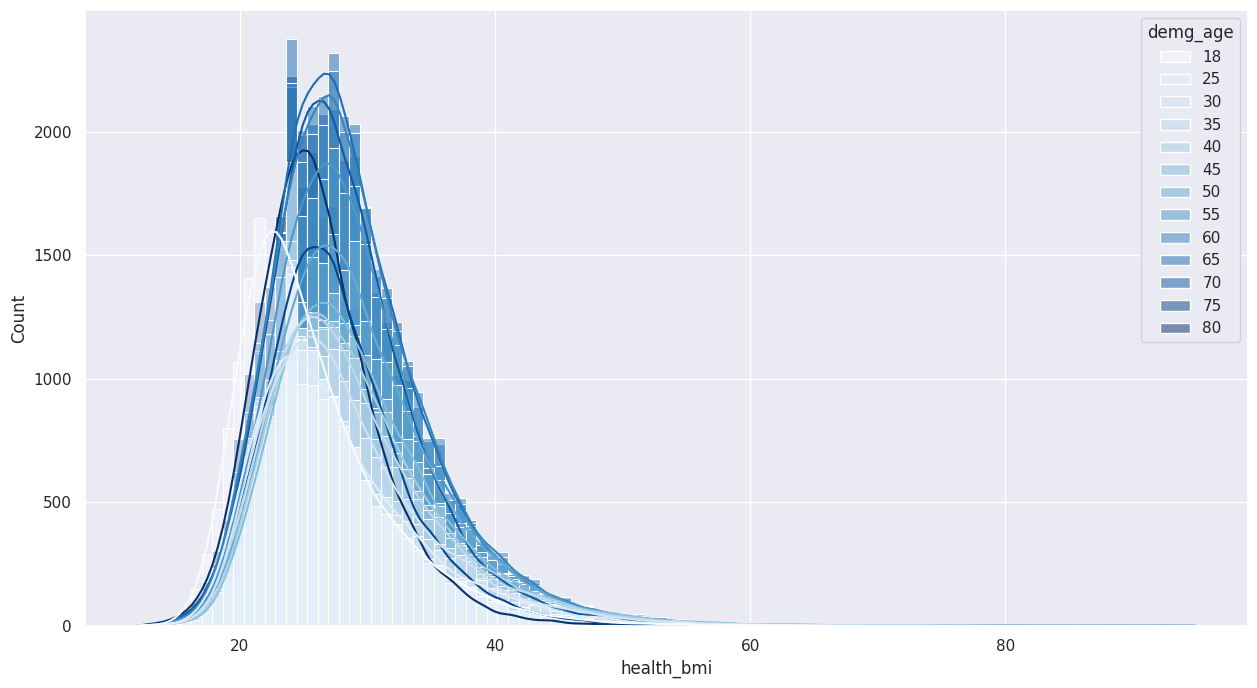

In [ ]:
sns.histplot(x='health_bmi', hue='demg_age',
             kde=True, data=heart_disease_df_map, bins=100, palette='Blues');

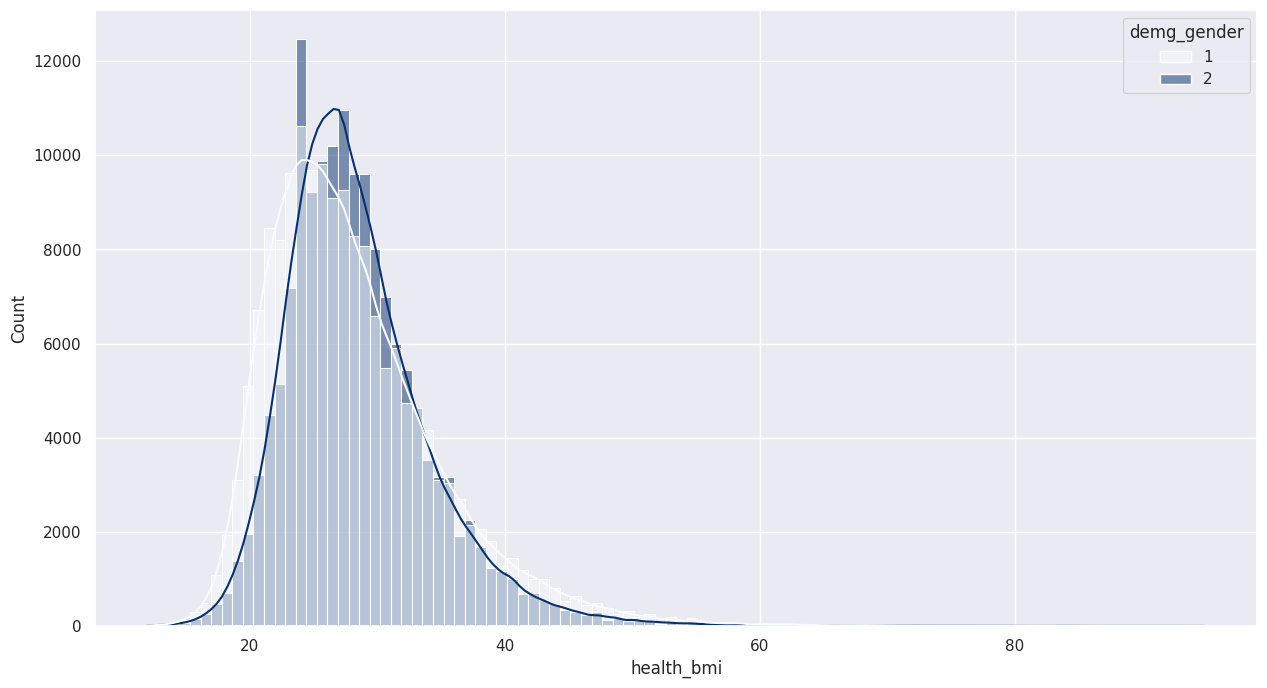

In [ ]:
sns.histplot(x='health_bmi', hue='demg_gender',
             kde=True, data=heart_disease_df_map, bins=100, palette='Blues');

### 3.3 Evaluation Metrics <a id='33'></a>

* **Recall** to maximize on patients who are true positives for heart disease.
* **ROC AUC** to identify high vs low risk patients.

[back to top](#top)

# **4 | Validation**

Validation and testing scheme to use in [model selection](#7).

In [27]:
# separate target from features
y = heart_disease_df_map['y_heart_disease']
X = heart_disease_df_map.loc[:, [
    'behavior_activity',
    'behavior_alcohol',
    'behavior_sleep',
    'behavior_tobacco',
    'demg_age',
    'demg_gender',
    'demg_race',
    'disease_asthma',
    'disease_diabetes',
    'disease_kidney',
    'disease_skin',
    'disease_stroke',
    'health_bmi',
    'health_general',
    'health_mental',
    'health_mobility',
    'health_physical'
    ]]
# double split for test/train/validate
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size = .25,
                                                  random_state = 42)
# scale X train/test/validate
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)
X_scaled = scaler.transform(X)


# **5 | Baseline**

Logistic regression with three features based on correlation matrix.

In [28]:
# separate target from three features based on the correlation matrix
y_base = heart_disease_df_map['y_heart_disease']
X_base = heart_disease_df_map.loc[:, [
    'demg_age',
    'health_mobility',
    'health_physical']]

# double split for test/train/validate
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base,
                                             y_base,
                                             test_size=0.2,
                                             random_state=42)
X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(X_train_base,
                                            y_train_base,
                                            test_size = .25,
                                            random_state = 42)
# scale baseline X train/test
scaler = StandardScaler()
X_train_scaled_base = scaler.fit_transform(X_train_base)
X_test_scaled_base = scaler.transform(X_test_base)
X_val_scaled_base = scaler.transform(X_val_base)
X_scaled_base = scaler.transform(X_base)


In [29]:
# baseline logistic regression X train scaled & y train
log_reg_base = LogisticRegression()
log_reg_base.fit(X_train_scaled_base, y_train_base)

# baseline predict on X_validate_scaled_m
y_pred_base = log_reg_base.predict(X_val_scaled_base)

In [61]:
# score on recall and roc auc
zero = ['Baseline logistic regression','log_reg_base',
        'Recall:', round(recall_score(y_val_base, y_pred_base), 4),
        'ROC AUC:',round(roc_auc_score(y_val_base, log_reg_base.predict_proba(X_val_scaled_base)[:,1]), 4)]
zero

['Baseline logistic regression',
 'log_reg_base',
 'Recall:',
 0.0213,
 'ROC AUC:',
 0.7858]

# **6 | Feature Engineering** <a id='fe'></a>

### Features: Question groups
Groups of similar survey question questions as defined by [data dictionary](https://www.cdc.gov/brfss/annual_data/2020/pdf/codebook20_llcp-v2-508.pdf).

In [139]:
# 1 behaviors = physical activity days/month + sleep time hrs/day + alcohol + tobacco use
heart_disease_df_map['behaviors'] = (
    heart_disease_df_map['behavior_activity'] +
    heart_disease_df_map['behavior_alcohol'] +
    heart_disease_df_map['behavior_sleep'] +
    heart_disease_df_map['behavior_tobacco'])

# 2 demographics = age + gender + race
heart_disease_df_map['demographics'] = (
    heart_disease_df_map['demg_age'] +
    heart_disease_df_map['demg_gender'] +
    heart_disease_df_map['demg_race'])

# 3 disease = asthma + diabetes + kidney + skin cancer + stroke
heart_disease_df_map['disease'] = (
    heart_disease_df_map['disease_asthma'] +
    heart_disease_df_map['disease_diabetes'] +
    heart_disease_df_map['disease_kidney'] +
    heart_disease_df_map['disease_skin'] +
    heart_disease_df_map['disease_stroke'])

# 4 (health) measures = bmi + general health + mental + mobility + physical
heart_disease_df_map['measures'] = (
    heart_disease_df_map['health_bmi'] +
    heart_disease_df_map['health_general'] +
    heart_disease_df_map['health_mental'] +
    heart_disease_df_map['health_mobility'] +
    heart_disease_df_map['health_physical'])

heart_disease_df_map.columns


Index(['behavior_activity', 'behavior_alcohol', 'behavior_sleep',
       'behavior_tobacco', 'demg_age', 'demg_gender', 'demg_race',
       'disease_asthma', 'disease_diabetes', 'disease_kidney', 'disease_skin',
       'disease_stroke', 'health_bmi', 'health_general', 'health_mental',
       'health_mobility', 'health_physical', 'y_heart_disease', 'behaviors',
       'demographics', 'disease', 'measures'],
      dtype='object')

In [140]:
heart_disease_df_map.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   behavior_activity  319795 non-null  int64  
 1   behavior_alcohol   319795 non-null  int64  
 2   behavior_sleep     319795 non-null  float64
 3   behavior_tobacco   319795 non-null  int64  
 4   demg_age           319795 non-null  int64  
 5   demg_gender        319795 non-null  int64  
 6   demg_race          319795 non-null  int64  
 7   disease_asthma     319795 non-null  int64  
 8   disease_diabetes   319795 non-null  int64  
 9   disease_kidney     319795 non-null  int64  
 10  disease_skin       319795 non-null  int64  
 11  disease_stroke     319795 non-null  int64  
 12  health_bmi         319795 non-null  float64
 13  health_general     319795 non-null  int64  
 14  health_mental      319795 non-null  float64
 15  health_mobility    319795 non-null  int64  
 16  he

### Features: Risk factors
Heart disease risk factors as outlined by [CDC](https://www.cdc.gov/heartdisease/facts.htm).

In [141]:
# risk factors = diabetes + bmi + physical activity + alcohol
heart_disease_df_map['risk_factors'] = (
    heart_disease_df_map['disease_diabetes'] +
    heart_disease_df_map['health_bmi'] +
    heart_disease_df_map['behavior_activity'] +
    heart_disease_df_map['behavior_alcohol'])

heart_disease_df_map.columns

Index(['behavior_activity', 'behavior_alcohol', 'behavior_sleep',
       'behavior_tobacco', 'demg_age', 'demg_gender', 'demg_race',
       'disease_asthma', 'disease_diabetes', 'disease_kidney', 'disease_skin',
       'disease_stroke', 'health_bmi', 'health_general', 'health_mental',
       'health_mobility', 'health_physical', 'y_heart_disease', 'behaviors',
       'demographics', 'disease', 'measures', 'risk_factors'],
      dtype='object')

In [142]:
# correlation matrix subset
heart_disease_df_map[['y_heart_disease',
                      'behaviors',
                      'demographics',
                      'disease',
                      'measures',
                      'risk_factors']].corr().style.background_gradient(cmap='Blues')

,y_heart_disease,behaviors,demographics,disease,measures,risk_factors
y_heart_disease,1.000000,0.009616,0.233874,0.210036,0.119176,0.053805
behaviors,0.009616,1.000000,0.097460,-0.021126,-0.133773,-0.064085
demographics,0.233874,0.097460,1.000000,0.230155,-0.035811,-0.000299
disease,0.210036,-0.021126,0.230155,1.000000,0.205334,0.207090
measures,0.119176,-0.133773,-0.035811,0.205334,1.000000,0.513235
risk_factors,0.053805,-0.064085,-0.000299,0.207090,0.513235,1.000000


In [143]:
heart_disease_df_map.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   behavior_activity  319795 non-null  int64  
 1   behavior_alcohol   319795 non-null  int64  
 2   behavior_sleep     319795 non-null  float64
 3   behavior_tobacco   319795 non-null  int64  
 4   demg_age           319795 non-null  int64  
 5   demg_gender        319795 non-null  int64  
 6   demg_race          319795 non-null  int64  
 7   disease_asthma     319795 non-null  int64  
 8   disease_diabetes   319795 non-null  int64  
 9   disease_kidney     319795 non-null  int64  
 10  disease_skin       319795 non-null  int64  
 11  disease_stroke     319795 non-null  int64  
 12  health_bmi         319795 non-null  float64
 13  health_general     319795 non-null  int64  
 14  health_mental      319795 non-null  float64
 15  health_mobility    319795 non-null  int64  
 16  he

# **7 | Class Imblance Handling** <a id='cih'></a>

In [ ]:
# target imbalance
heart_disease_df_map.y_heart_disease.value_counts()

0    292422
1     27373
Name: y_heart_disease, dtype: int64

In [ ]:
heart_disease_df_map.head()

,behavior_activity,behavior_alcohol,behavior_sleep,behavior_tobacco,demg_age,demg_gender,demg_race,disease_asthma,disease_diabetes,disease_kidney,disease_skin,disease_stroke,health_bmi,health_general,health_mental,health_mobility,health_physical,y_heart_disease
0,1,0,5.0,1,55,1,6,1,1,0,1,0,16.60,4,30.0,0,3.0,0
1,1,0,7.0,0,80,1,6,0,0,0,0,1,20.34,4,0.0,0,0.0,0
2,1,0,8.0,1,65,2,6,1,1,0,0,0,26.58,2,30.0,0,20.0,0
3,0,0,6.0,0,75,1,6,0,0,0,1,0,24.21,3,0.0,0,0.0,0
4,1,0,8.0,0,40,1,6,0,0,0,0,0,23.71,4,0.0,1,28.0,0


# **8 | Model Iterations**

### 1 Dummy Classifier<a id='61'></a>

In [62]:
clf = DummyClassifier(strategy= 'most_frequent')
clf.fit(X_train,y_train)
y_pred_clf = clf.predict(X_val_scaled)

In [63]:
one = ['Dummy classifier', 'clf',
        'Recall:', round(recall_score(y_val, y_pred_clf), 4),
        'ROC AUC:',round(roc_auc_score(y_val, clf.predict_proba(X_val_scaled)[:,1]), 4)]

one

['Dummy classifier', 'clf', 'Recall:', 0.0, 'ROC AUC:', 0.5]

*   Dummy classifier performed worse than [baseline](#4).



### 2 Logistic Regression<a id='62'></a>

In [59]:
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_val_scaled)

In [60]:
two = ["Logistic regression", 'log_reg',
        'Recall:', round(recall_score(y_val, y_pred_log_reg), 4),
        'ROC AUC:',round(roc_auc_score(y_val, log_reg.predict_proba(X_val_scaled)[:,1]), 4)]
two

['Logistic regression', 'log_reg', 'Recall:', 0.0995, 'ROC AUC:', 0.8411]

*   Logistic regression (with all features) performed better than [baseline]



In [ ]:
# confusion matrix for log_reg
cm_log_reg = confusion_matrix(y_val, y_pred_log_reg)
cm_log_reg

array([[57968,   505],
       [ 4940,   546]])

### 3 Decision Trees: Depth=2<a id='63'></a>

In [66]:
dt_2 = DecisionTreeClassifier(max_depth=2,criterion="entropy")
dt_2.fit(X_train, y_train)
y_pred_dt_2 = dt_2.predict(X_val)

In [67]:
three = ["Decision tree (depth=2)", 'dt_2',
        'Recall:', round(recall_score(y_val, y_pred_dt_2), 4),
        'ROC AUC:',round(roc_auc_score(y_val, dt_2.predict_proba(X_val)[:,1]), 4)]
three

['Decision tree (depth=2)', 'dt_2', 'Recall:', 0.0, 'ROC AUC:', 0.7654]

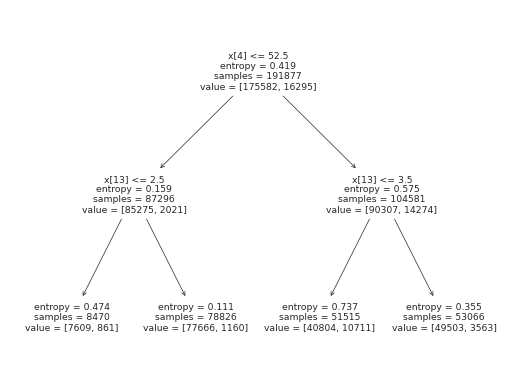

In [ ]:
tree.plot_tree(dt_2);

### 4 Decision Trees: Depth=4<a id='64'></a>

In [68]:
dt_4 = DecisionTreeClassifier(max_depth=4,criterion="entropy")
dt_4.fit(X_train, y_train)
y_pred_dt_4 = dt_4.predict(X_val)

In [71]:
four = ["Decision tree (depth=4)", 'dt_4',
        'Recall:', round(recall_score(y_val, y_pred_dt_4), 4),
        'ROC AUC:',round(roc_auc_score(y_val, dt_4.predict_proba(X_val)[:,1]), 4)]
four

['Decision tree (depth=4)', 'dt_4', 'Recall:', 0.0, 'ROC AUC:', 0.8113]

In [ ]:
tree.plot_tree(dt_4);

*   Decision trees performed worse than [logistic regression](#62).

### 5 Random Forests <a id='65'></a>

In [73]:
forest = RandomForestClassifier().fit(X_train, y_train)
y_pred_forest = forest.predict(X_val)

In [74]:
five = ["Random forest", 'forest',
        'Recall:', round(recall_score(y_val, y_pred_forest), 4),
        'ROC AUC:', round(roc_auc_score(y_val, forest.predict_proba(X_val)[:,1]), 4)]
five

['Random forest', 'forest', 'Recall:', 0.1179, 'ROC AUC:', 0.7977]

*   Random forest performed **better** ('Recall:', 0.1179) than logistic regression ('Recall:', 0.0995).

### 6 Gradient Boosted Trees: xgboost<a id='66'></a>

In [75]:
gbm = xgb.XGBRegressor(
                    n_estimators=30000,
                    max_depth=3,
                    objective="binary:logistic",
                    eval_metric='auc',
                    learning_rate=.1,
                    subsample=1,
                    min_child_weight=1,
                    colsample_bytree=.8
                    )
eval_set=[(X_train, y_train),(X_val,y_val)]



In [ ]:
gbm_fit = gbm.fit(X_train, y_train,
                  eval_set=eval_set,
                  early_stopping_rounds=20,
                  verbose=True)
y_pred_gbm = gbm.predict(X_val)

In [ ]:
# [216]	validation_0-auc:0.84859	validation_1-auc:0.84469

In [90]:
six = ["XGBoost", 'gbm',
        'Recall:', round(recall_score(y_val, np.round(gbm.predict(X_val))), 4),
        'ROC AUC:', round(roc_auc_score(y_val, np.round(gbm.predict(X_val)))), 4]
six

['XGBoost', 'gbm', 'Recall:', 0.0829, 'ROC AUC:', 1, 4]

### 7 Naive Bayes: Bernoulli<a id='67'></a>

In [108]:
bern = BernoulliNB().fit(X_train, y_train)
y_predict_bern = bern.predict(X_val)

In [109]:
seven = ["Bernoulli NB", 'bern',
        'Recall:', round(recall_score(y_val, y_predict_bern), 4),
        'ROC AUC:',round(roc_auc_score(y_val, bern.predict_proba(X_val)[:,1]), 4)]
seven

['Bernoulli NB', 'bern', 'Recall:', 0.2275, 'ROC AUC:', 0.7624]

*   Naive Bayes Bernoulli performed **better** ('Recall:', 0.2275) than logistic regression ('Recall:', 0.0995).




### 8 Naive Bayes: Gaussian<a id='68'></a>

In [110]:
gaus = GaussianNB().fit(X_train, y_train)
y_pred_gaus = gaus.predict(X_val)

In [111]:
eight = ["Gaussian NB",'gaus',
        'Recall:', round(recall_score(y_val, y_pred_gaus), 4),
        'ROC AUC:',round(roc_auc_score(y_val, gaus.predict_proba(X_val)[:,1]), 4)]
eight

['Gaussian NB', 'gaus', 'Recall:', 0.471, 'ROC AUC:', 0.8053]

*   Naive Bayes Gaussian performed **better** ('Recall:', 0.471).





### 9 Naive Bayes: Multinomial<a id='69'></a>

In [112]:
multi = MultinomialNB().fit(X_train, y_train)
y_pred_multi = multi.predict(X_val)

In [115]:
nine = ["Multinomial NB", 'multi',
        'Recall:', round(recall_score(y_val, y_pred_multi), 4),
        'ROC AUC:',round(roc_auc_score(y_val, multi.predict_proba(X_val)[:,1]), 4)]
nine

['Multinomial NB', 'multi', 'Recall:', 0.3359, 'ROC AUC:', 0.7628]

### 10 Ensemble: Naive Bayes Hard Voting Classifier <a id='610'></a>

In [135]:
# set up voting classifier ensemble
nb_names = ['bern', 'gaus', 'multi']
nb_vars = [eval(n) for n in nb_names]

nb_list = list(zip(nb_names, nb_vars))
nb_list

[('bern', BernoulliNB()), ('gaus', GaussianNB()), ('multi', MultinomialNB())]

In [136]:
vote_hard = VotingClassifier(estimators= nb_list,
                             voting='hard',
                             n_jobs=-1)
vote_hard.fit(X_train, y_train)
y_pred_hard = vote_hard.predict(X_val)

In [137]:
ten = ["Hard NB Voting Classifier", 'vote_hard',
        'Recall:', round(recall_score(y_val, y_pred_hard), 4),
        'ROC AUC:',round(roc_auc_score(y_val, vote_hard.predict(X_val)), 4)]
ten

['Hard NB Voting Classifier',
 'vote_hard',
 'Recall:',
 0.3451,
 'ROC AUC:',
 0.6335]

### 11 Ensemble: Naive Bayes Soft Voting Classifier <a id='611'></a>

In [128]:
vote_soft = VotingClassifier(estimators= nb_list,
                             voting='soft',
                             n_jobs=-1)
vote_soft.fit(X_train, y_train)
y_pred_soft = vote_soft.predict(X_val)

In [132]:
eleven = ["Soft NB Voting Classifier", 'vote_soft',
        'Recall:', round(recall_score(y_val, y_pred_hard), 4),
        'ROC AUC:',round(roc_auc_score(y_val, vote_soft.predict_proba(X_val)[:,1]), 4)]
eleven

['Soft NB Voting Classifier',
 'vote_soft',
 'Recall:',
 0.3451,
 'ROC AUC:',
 0.7759]

## precision and recall curves for X/y_val


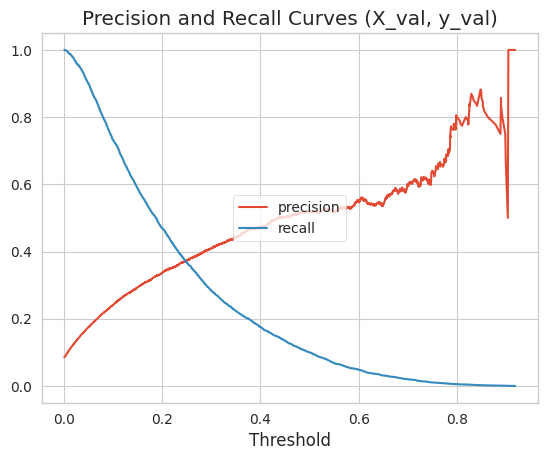

In [133]:
# precision and recall curves for X/y_val
y_pred = log_reg.predict(X_val_scaled)

precision_curve, recall_curve, threshold_curve = precision_recall_curve(
    y_val, log_reg.predict_proba(X_val_scaled)[:,1] )

# f, ax = plt.subplots(figsize=(10, 6))
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='center')
plt.xlabel('Threshold');
plt.title('Precision and Recall Curves (X_val, y_val)')
plt.savefig("precision-recall-curves.jpeg");

## 13 Logistic regression: question groups<a id='613'></a>

In [144]:
# separate target from question groups features: y/X_grp
y_grp = heart_disease_df_map['y_heart_disease']
X_grp = heart_disease_df_map.loc[:, ['behaviors',
                                     'demographics',
                                     'disease',
                                     'measures']]
# double split for test/train/validate
X_train_grp, X_test_grp, y_train_grp, y_test_grp = train_test_split(X_grp,
                                           y_grp,
                                           test_size=0.2,
                                           random_state=42)
X_train_grp, X_val_grp, y_train_grp, y_val_grp = train_test_split(X_train_grp,
                                          y_train_grp,
                                          test_size = .25,
                                          random_state = 42)
# scale X train/test/validate
scaler = StandardScaler()
X_train_grp_scaled = scaler.fit_transform(X_train_grp)
X_test_grp_scaled = scaler.transform(X_test_grp)
X_val_grp_scaled = scaler.transform(X_val_grp)

In [145]:
# logistic regression question groups features
log_reg_grp = LogisticRegression()
log_reg_grp.fit(X_train_grp_scaled, y_train_grp)
y_pred_grp = log_reg_grp.predict(X_val_grp_scaled)

In [149]:
thirteen = ["Logistic regression group features", 'log_reg_grp',
        'Recall:', round(recall_score(y_val, y_pred_grp), 4),
        'ROC AUC:',round(roc_auc_score(y_val,
                                       log_reg_grp.predict_proba(X_val_grp_scaled)[:,1]), 4)]
thirteen

['Logistic regression group features',
 'log_reg_grp',
 'Recall:',
 0.0244,
 'ROC AUC:',
 0.7972]

## 14 Logistic regression: risk factors<a id='614'></a>

In [150]:
# separate target from engineered features: y/X_risk
y_risk = heart_disease_df_map['y_heart_disease']
X_risk = heart_disease_df_map.loc[:, ['disease_diabetes',
                                      'health_bmi',
                                      'behavior_activity',
                                      'behavior_alcohol']]
# double split for test/train/validate
X_train_risk, X_test_risk, y_train_risk, y_test_risk = train_test_split(X_risk,
                                             y_risk,
                                             test_size=0.2,
                                             random_state=42)
X_train_risk, X_val_risk, y_train_risk, y_val_risk = train_test_split(X_train_risk,
                                            y_train_risk,
                                            test_size = .25,
                                            random_state = 42)
# scale X train/test/validate
scaler = StandardScaler()
X_train_risk_scaled = scaler.fit_transform(X_train_risk)
X_test_risk_scaled = scaler.transform(X_test_risk)
X_val_risk_scaled = scaler.transform(X_val_risk)

In [151]:
# logistic regression risk factor features
log_reg_risk = LogisticRegression()
log_reg_risk.fit(X_train_risk_scaled, y_train_risk)
y_pred_risk = log_reg_risk.predict(X_val_risk_scaled)

In [160]:
fourteen = ["Logistic regression risk factor features", 'log_reg_risk',
        'Recall:', round(recall_score(y_val, y_pred_risk), 4),
        'ROC AUC:',round(roc_auc_score(y_val,
                                       log_reg_risk.predict_proba(X_val_risk_scaled)[:,1]), 4)]
fourteen

['Logistic regression risk factor features',
 'log_reg_risk',
 'Recall:',
 0.0,
 'ROC AUC:',
 0.646]

## 15 Logistic regression: question groups + risk factor features<a id='615'></a>

In [155]:
# separate target from question groups + risk factor features: y/X_grp_risk
y_grp_risk = heart_disease_df_map['y_heart_disease']
X_grp_risk = heart_disease_df_map.loc[:, [
    'behaviors',
    'demographics',
    'disease',
    'measures',
    'behavior_activity',
    'behavior_alcohol',
    'disease_diabetes',
    'health_bmi']]
# double split for test/train/validate
X_train_grp_risk, X_test_grp_risk, y_train_grp_risk, y_test_grp_risk = train_test_split(X_grp_risk,
                                                    y_grp_risk,
                                                    test_size=0.2,
                                                    random_state=42)
X_train_grp_risk, X_val_grp_risk, y_train_grp_risk, y_val_grp_risk = train_test_split(X_train_grp_risk,
                                                    y_train_grp_risk,
                                                    test_size = .25,
                                                    random_state = 42)
# scale X train/test/validate
scaler = StandardScaler()
X_train_grp_risk_scaled = scaler.fit_transform(X_train_grp_risk)
X_test_grp_risk_scaled = scaler.transform(X_test_grp_risk)
X_val_grp_risk_scaled = scaler.transform(X_val_grp_risk)

In [156]:
# logistic regression question groups + risk factor features
log_reg_grp_risk = LogisticRegression()
log_reg_grp_risk.fit(X_train_grp_risk_scaled, y_train_grp_risk)
y_pred_grp_risk = log_reg_grp_risk.predict(X_val_grp_risk_scaled)

In [159]:
fifteen = ["Logistic regression question groups + risk factor features",
           'log_reg_grp_risk',
        'Recall:', round(recall_score(y_val, y_pred_grp_risk), 4),
        'ROC AUC:',round(roc_auc_score(y_val,
                                       log_reg_grp_risk.predict_proba(X_val_grp_risk_scaled)[:,1]), 4)]
fifteen

['Logistic regression question groups + risk factor features',
 'log_reg_grp_risk',
 'Recall:',
 0.0321,
 'ROC AUC:',
 0.7998]

## 16 Logistic regression: threshold = 0.05<a id='616'></a>


In [180]:
# decision threshold = 0.05 based on precision and recall curves
y_predict = (log_reg.predict_proba(X_val_scaled)[:,1] > 0.05)

sixteen = ["Logistic regression threshold = 0.05", 'log_reg',
        'Recall:', round(recall_score(y_val, y_predict), 4),
        'ROC AUC:',round(roc_auc_score(y_val,
                                       log_reg.predict_proba(X_val_scaled)[:,1]), 4)]
sixteen

['Logistic regression threshold = 0.05',
 'log_reg',
 'Recall:',
 0.8994,
 'ROC AUC:',
 0.8411]

*   Logistic regression (threshold=0.5) performed **better** ('Recall:', 0.8994).


## 17 Logistic regression: GridSearchCV<a id='617'></a>

In [165]:
# find best C params and penalty type
grid={"C": np.logspace(-3,3,7), "penalty":["l1","l2"]}# L1 lasso, L2 ridge
logreg = LogisticRegression()
logregcv = GridSearchCV(logreg, grid, cv=10)
logregcv.fit(X_train,y_train)

print("Tuned Hpyerparameters :(best parameters) ", logregcv.best_params_)
print("Accuracy :", logregcv.best_score_)

Tuned Hpyerparameters :(best parameters)  {'C': 0.001, 'penalty': 'l2'}
Accuracy : 0.915904455451176


In [178]:
# score model on X_val with best GridSearchCV params and threshold = default
log_reg_gridcv = LogisticRegression(C=0.01, penalty="l2")
log_reg_gridcv.fit(X_train_scaled, y_train)

y_pred_log_reg_gridcv = log_reg_gridcv.predict(X_val_scaled)

In [179]:
seventeen = ['Log reg GridSearchCV + threshold = default',
             'log_reg_gridcv',
        'Recall:', round(recall_score(y_val, y_pred_log_reg_gridcv), 4),
        'ROC AUC:',round(roc_auc_score(y_val,
                                       log_reg_gridcv.predict_proba(X_val_scaled)[:,1]), 4)]
seventeen

['Log reg GridSearchCV + threshold = default',
 'log_reg_gridcv',
 'Recall:',
 0.0984,
 'ROC AUC:',
 0.8412]

## 18 Logistic regression: GridSearchCV + threshold = 0.05<a id='618'></a>

In [171]:
# score model on X_val with best GridSearchCV params and threshold = 0.05
log_reg_gridcv_2 = LogisticRegression(C=0.01, penalty="l2")
log_reg_gridcv_2.fit(X_train_scaled, y_train)
y_pred_log_reg_gridcv_2 = (log_reg_gridcv_2.predict_proba(X_val_scaled)[:,1] > 0.05)

In [189]:
eighteen = ['Log reg GridSearchCV + threshold =0.05',
            'log_reg_gridcv_2',
            'Recall:', round(recall_score(y_val, y_pred_log_reg_gridcv_2), 4),
            'ROC AUC:',round(roc_auc_score(y_val,
                                       log_reg_gridcv_2.predict_proba(X_val_scaled)[:,1]), 4)]
eighteen

['Log reg GridSearchCV + threshold =0.05',
 'log_reg_gridcv_2',
 'Recall:',
 0.901,
 'ROC AUC:',
 0.8412]

*   Logistic regression (threshold=0.5) with GridSearchCV tuning performed **best** ('Recall:', 0.901).

## Best Performing Model <a id='bpm'></a>

In [213]:
# df to summarize 18 model performance
models = [zero, one, two, three, four, five, six, seven, eight,
          nine,ten, eleven, thirteen, fourteen, fifteen,
          sixteen, seventeen, eighteen]
model_eval = pd.DataFrame(data = models)

model_eval = model_eval.drop([2,4,6], axis=1)
model_eval.head(1)

,0,1,3,5
0,Baseline logistic regression,log_reg_base,0.0213,0.7858


In [ ]:
model_eval = model_eval.rename(columns={0:'Model',1: 'Variable',
                                        3: 'Recall',5:'ROC AUC'})

In [219]:
model_eval.sort_values(by=['Recall', 'ROC AUC'], ascending=False).head(2)

,Model,Variable,Recall,ROC AUC
17,Log reg GridSearchCV + threshold =0.05,log_reg_gridcv_2,0.9010,0.8412
15,Logistic regression threshold = 0.05,log_reg,0.8994,0.8411



*   Best perfoming model: `log_reg_gridcv`
*   Recall = 0.9010
*   ROC AUC = 0.8412







#**9 | Model: Predicting Heart Disease**

### 1 Test Model<a id='71'></a>

In [223]:
heart_disease_model = LogisticRegression(C=0.01, penalty="l2")
heart_disease_model.fit(X_test_scaled, y_test)
y_pred = (heart_disease_model.predict_proba(X_test_scaled)[:,1] > 0.05)

score = {
    'Model': 'heart_disease_model on test_scaled data',
    'Variable': 'heart_disease_model',
    'Recall': round(recall_score(y_val, y_pred), 6),
    'ROC AUC': round(roc_auc_score(y_val, heart_disease_model.predict_proba(X_val_scaled)[:,1]), 6)}
score

{'Model': 'heart_disease_model on test_scaled data',
 'Variable': 'heart_disease_model',
 'Recall': 0.472293,
 'ROC AUC': 0.841403}

### 2 Model Evaluation <a id='72'></a>

In [224]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[33643, 24724],
       [  537,  5055]])

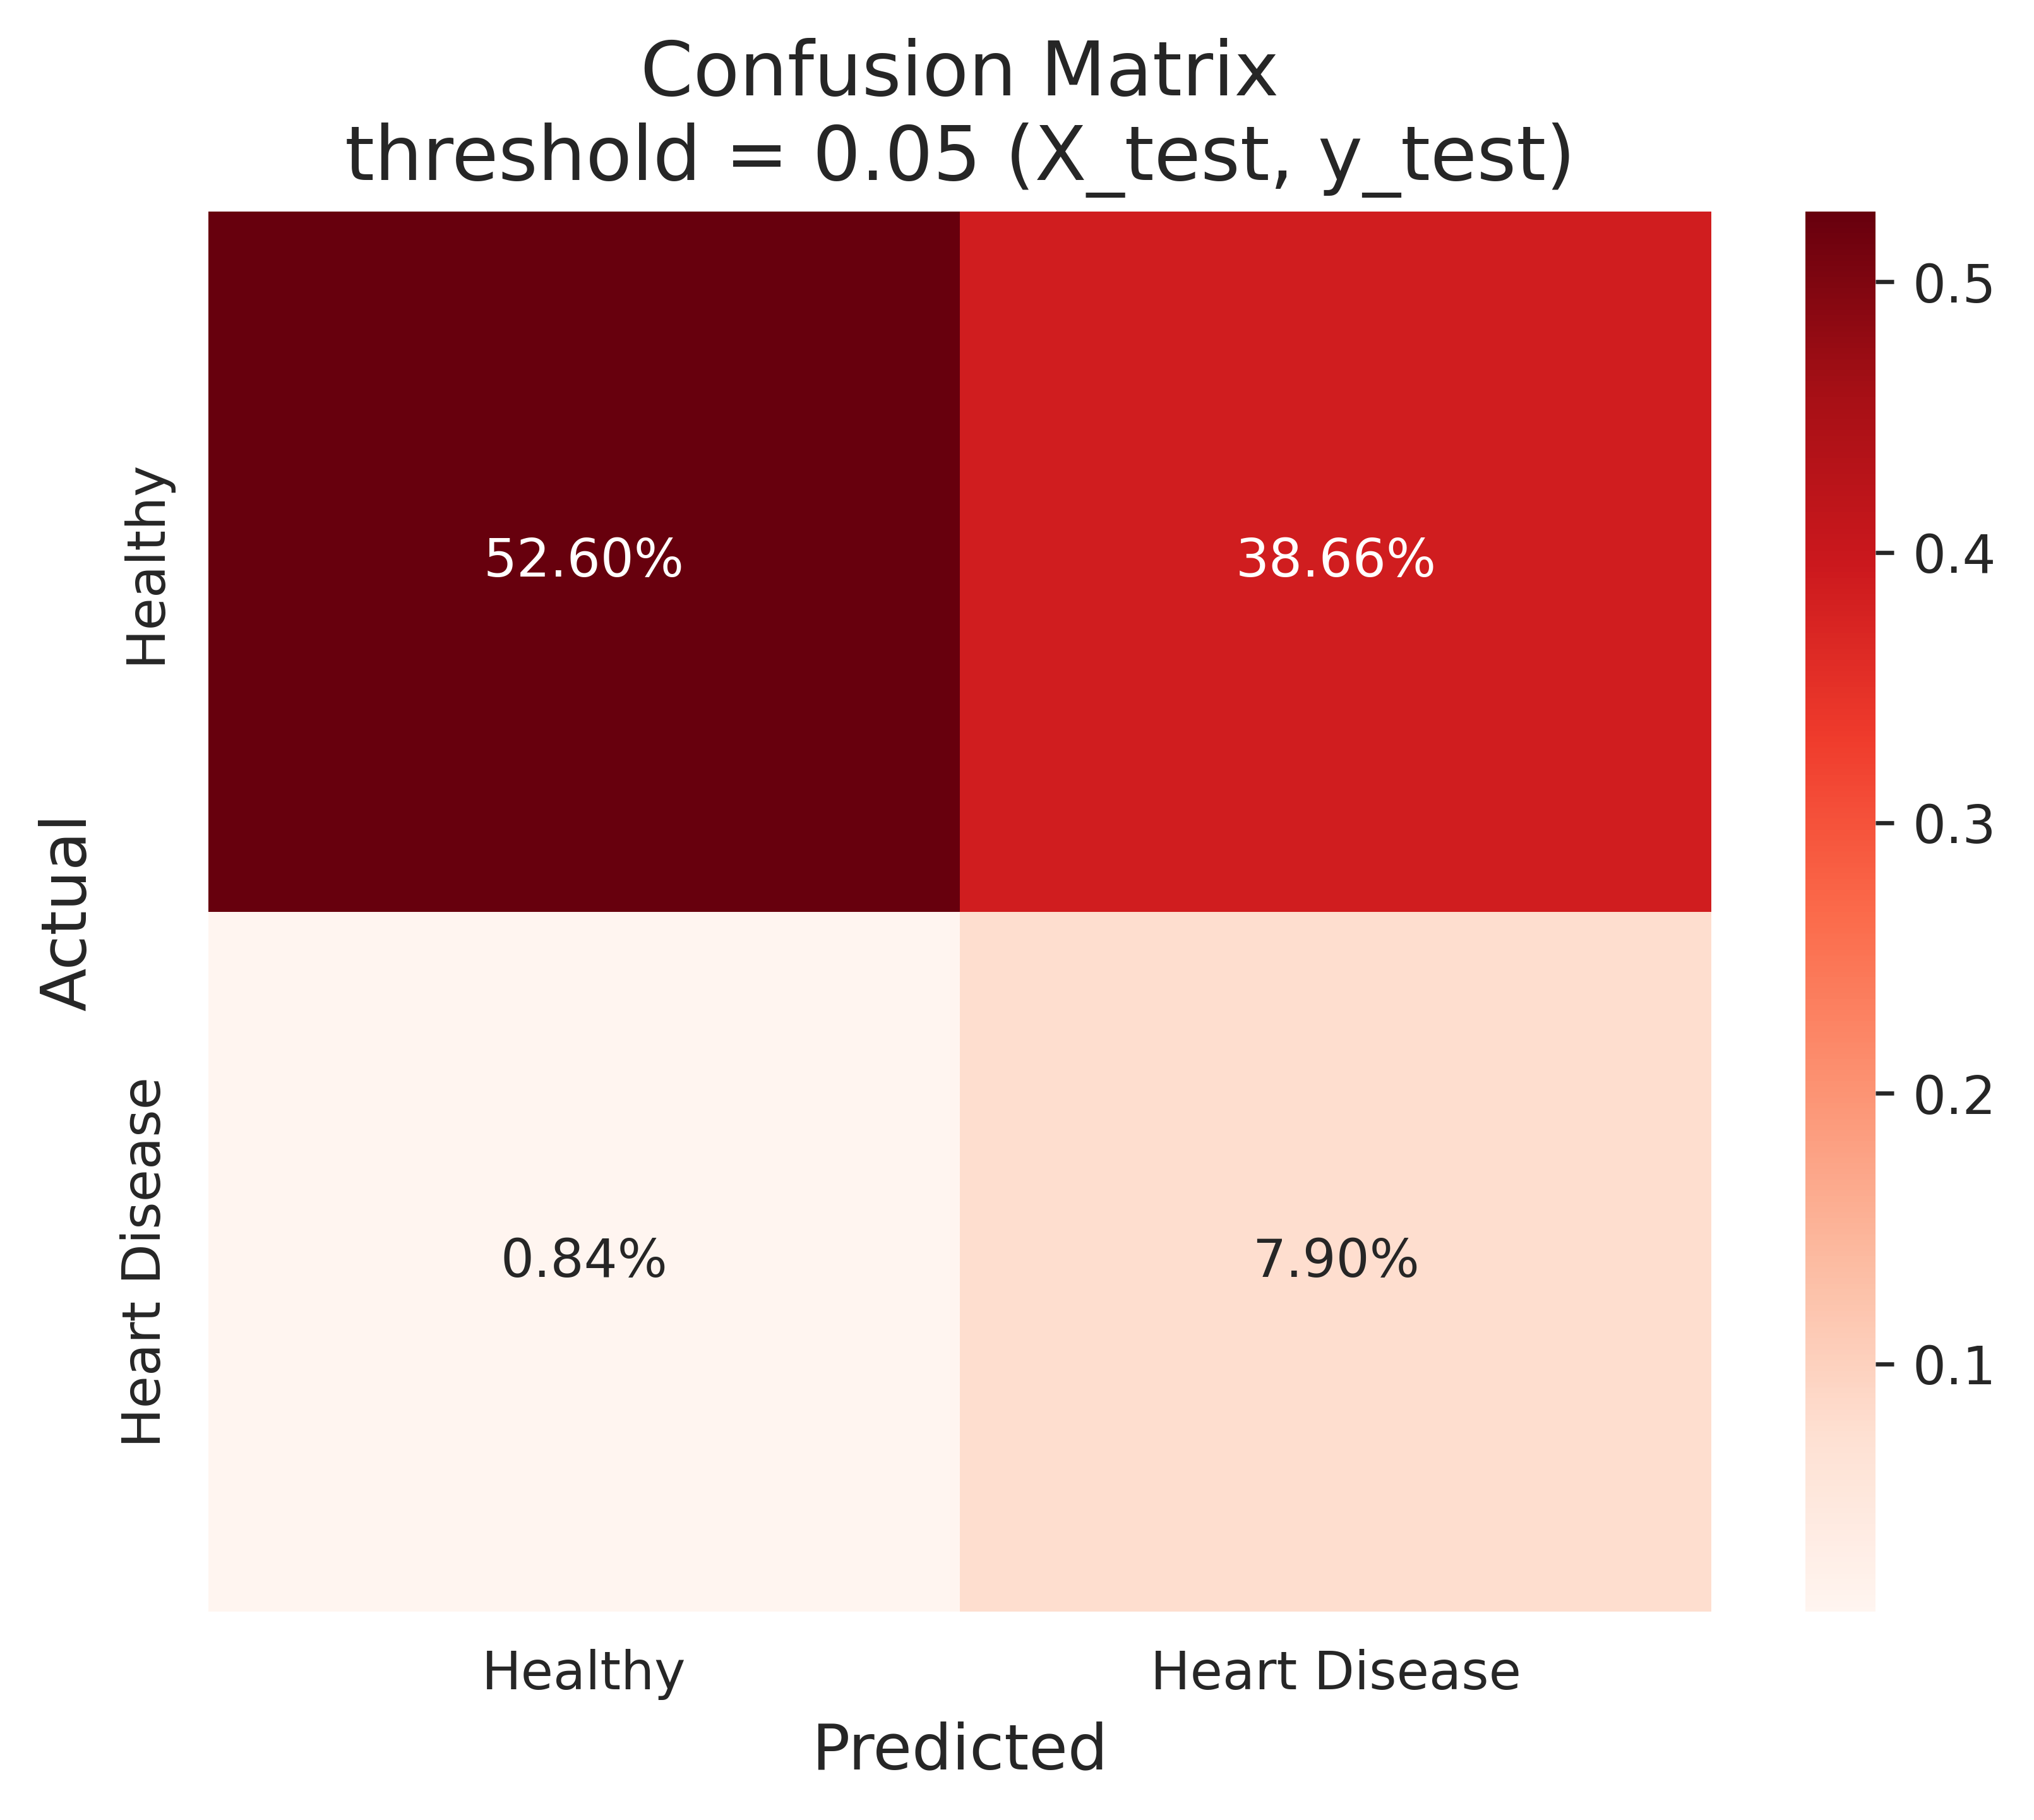

In [225]:
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600

ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='Reds')

ax.xaxis.set_ticklabels(['Healthy','Heart Disease'])
ax.yaxis.set_ticklabels(['Healthy','Heart Disease'])

plt.title('Confusion Matrix' '\n' 'threshold = 0.05 (X_test, y_test)')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

plt.savefig("confusion-matrix.jpeg");

In [226]:
# classification report
print(classification_report(y_test, y_pred))
#                             final_model.predict(X_test_scaled),
#                             target_names=['no heart disease', 'yes heart disease']

              precision    recall  f1-score   support

           0       0.98      0.58      0.73     58367
           1       0.17      0.90      0.29      5592

    accuracy                           0.61     63959
   macro avg       0.58      0.74      0.51     63959
weighted avg       0.91      0.61      0.69     63959



### 3 ROC AUC ⚠️<a id='73'></a>

In [ ]:
# probs = final_model.predict_proba(X)
# preds = probs[:,1]
# fpr, tpr, threshold = roc_curve(y, preds)
# roc_auc = auc(fpr, tpr)

# plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)

# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])

# plt.title('ROC AUC Curve (X, y)')
# plt.legend(loc = 'lower right')
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')

# plt.savefig("roc-auc-curve.jpeg");

### 4 Correlations <a id='74'></a>

In [227]:
heart_disease_df_map.corr().style.background_gradient(cmap='Blues')

,behavior_activity,behavior_alcohol,behavior_sleep,behavior_tobacco,demg_age,demg_gender,demg_race,disease_asthma,disease_diabetes,disease_kidney,disease_skin,disease_stroke,health_bmi,health_general,health_mental,health_mobility,health_physical,y_heart_disease,behaviors,demographics,disease,measures,risk_factors
behavior_activity,1.000000,0.017487,0.003849,-0.097174,-0.121465,0.048247,0.056767,-0.041526,-0.097539,-0.081827,-0.001328,-0.079455,-0.150616,0.281249,-0.095808,-0.278524,-0.232283,-0.100030,0.240382,-0.114984,-0.121318,-0.232098,-0.091956
behavior_alcohol,0.017487,1.000000,-0.005065,0.111768,-0.058837,0.004200,0.036702,-0.002202,-0.042695,-0.028280,-0.005702,-0.019858,-0.038816,0.029780,0.051282,-0.035328,-0.017254,-0.032080,0.194463,-0.055611,-0.043052,0.002955,-0.001744
behavior_sleep,0.003849,-0.005065,1.000000,-0.030336,0.103071,-0.015704,0.035889,-0.048245,-0.005166,0.006238,0.041266,0.011900,-0.051822,0.063071,-0.119717,-0.022216,-0.061387,0.008327,0.900485,0.103835,-0.004723,-0.117913,-0.051761
behavior_tobacco,-0.097174,0.111768,-0.030336,1.000000,0.130384,0.085052,0.065499,0.024149,0.038993,0.034920,0.033977,0.061226,0.023118,-0.174717,0.085157,0.120074,0.115352,0.107764,0.276416,0.135549,0.070918,0.110274,0.024353
demg_age,-0.121465,-0.058837,0.103071,0.130384,1.000000,-0.067682,0.162777,-0.058235,0.154070,0.122697,0.262208,0.137280,-0.001740,-0.188236,-0.155455,0.242552,0.110789,0.232325,0.092926,0.997431,0.233773,-0.033017,0.001382
demg_gender,0.048247,0.004200,-0.015704,0.085052,-0.067682,1.000000,0.018855,-0.069191,-0.018350,-0.009084,0.013434,-0.003091,0.026940,0.025947,-0.100058,-0.068860,-0.040904,0.070040,0.025665,-0.038334,-0.039320,-0.065215,0.028421
demg_race,0.056767,0.036702,0.035889,0.065499,0.162777,0.018855,1.000000,-0.017975,-0.056252,0.003709,0.134780,-0.003956,-0.037424,0.057986,-0.014491,-0.015831,-0.000847,0.034854,0.073943,0.227730,0.002224,-0.021002,-0.036823
disease_asthma,-0.041526,-0.002202,-0.048245,0.024149,-0.058235,-0.069191,-0.017975,1.000000,0.044136,0.039707,-0.000396,0.038866,0.092345,-0.137342,0.114008,0.103222,0.117907,0.041444,-0.047690,-0.060647,0.464788,0.160077,0.092560
disease_diabetes,-0.097539,-0.042695,-0.005166,0.038993,0.154070,-0.018350,-0.056252,0.044136,1.000000,0.095186,0.024113,0.072476,0.163437,-0.204278,0.029970,0.152876,0.111644,0.118281,-0.025141,0.148064,0.744122,0.138095,0.240449
disease_kidney,-0.081827,-0.028280,0.006238,0.034920,0.122697,-0.009084,0.003709,0.039707,0.095186,1.000000,0.061816,0.091167,0.050768,-0.174642,0.037281,0.153064,0.142197,0.145197,-0.009583,0.121282,0.354756,0.111638,0.052116


### 5 Predictions <a id='75'></a>

In [229]:
# refit model to make predictions
heart_disease_model = LogisticRegression(C=0.01, penalty="l2")
heart_disease_model.fit(X_scaled, y)
y_pred = (heart_disease_model.predict_proba(X_scaled)[:,1] > 0.05)

heart_disease_model

LogisticRegression(C=0.01)

In [231]:
sample_1 = heart_disease_df_map.sample(1)
sample_1

,behavior_activity,behavior_alcohol,behavior_sleep,behavior_tobacco,demg_age,demg_gender,demg_race,disease_asthma,disease_diabetes,disease_kidney,...,health_general,health_mental,health_mobility,health_physical,y_heart_disease,behaviors,demographics,disease,measures,risk_factors
270469,1,0,6.0,1,45,1,6,0,0,0,...,4,0.0,0,1.0,0,8.0,52,0,28.63,24.63


In [232]:
print('Has heart disease?', sample_1['y_heart_disease'].values[0])

Has heart disease? 0


In [236]:
X_p1 = sample_1.drop('y_heart_disease', axis=1)
# X_p1.info()

In [ ]:
# X_p1 = X_p1.values[0]
# X_p1

In [ ]:
# print((X_p1))

In [ ]:
# # behavior_activity,behavior_alcohol,behavior_sleep,behavior_tobacco,demg_age,demg_gender,demg_race,disease_asthma,disease_diabetes,disease_kidney,disease_skin,disease_stroke,health_bmi,health_general,health_mental,health_mobility,health_physical
# X_p1 = [[1,0,5.0,1,55,1,6,1,1,0,1,0,16.6,4,30.0,0,3.0]]

Value references in [data dictionary](#1a) and [MVP transformations](https://github.com/slp22/classification-project/blob/main/classification-heart-disease_mvp.ipynb).


~Top 4 important features: age, gender, stroke, tobacco, kidney~

In [237]:
y_pred_p1 = heart_disease_model.predict(X_p1)
y_pred_p_p1 = heart_disease_model.predict_proba(X_p1)
print('Patient #1: middle aged, man, smoker, no chronic disease')
print('Yes/No heart disease:', y_pred_p1)
print('Probability of heart disease:', y_pred_p_p1)
print('Actual_y', sample_1['y_heart_disease'].values[0])

ValueError: ignored

In [230]:
# # 1: middle aged, man, smoker, no chronic disease

# X_p1 = [[60,  #'demg_age'     middle aged
#          2,  #'demg_gender'   male
#          0, #'disease_stroke'
#          1, #'behavior_tobacco' smoker
#          0, #'disease_kidney'

#          # rest of features will remain constant
#          1, #'behavior_activity' works out regularly
#          0, #'behavior_alcohol' not heavy drinker
#          7, #'behavior_sleep'  7 hrs sleep/night avg
#          6,  #'demg_race'     white
#          0, #'disease_asthma'
#          0, #'disease_diabetes'
#          0, #'disease_skin'
#          24, #'health_bmi'   normal bmi
#          3, #'health_general' health is good
#          2, #'health_mental' most days of month mental health is good
#          0, #'health_mobility' no mobility issues
#          2 #'health_physical most days of month physical health is good
#          ]]

# y_pred_p1 = heart_disease_model.predict(X_p1)
# y_pred_p_p1 = heart_disease_model.predict_proba(X_p1)
# print('Patient #1: middle aged, man, smoker, no chronic disease')
# print('Yes/No heart disease:', y_pred_p1, 'healthy')
# print('Probability of heart disease:', y_pred_p_p1)


Patient #1: middle aged, man, smoker, no chronic disease
Yes/No heart disease: [0] healthy
Probability of heart disease: [[0.65946415 0.34053585]]


In [ ]:
# 2: senior, female, stroke, smoker, kidney disease

X_p2 = [[80,  #'demg_age'     senior
         1,  #'demg_gender'   female
         1, #'disease_stroke' stroke
         1, #'behavior_tobacco' smoker
         1, #'disease_kidney'    kidney disease

         # rest of features will remain constant
         1, #'behavior_activity' works out regularly
         0, #'behavior_alcohol' not heavy drinker
         7, #'behavior_sleep'  7 hrs sleep/night avg
         6,  #'demg_race'     white
         0, #'disease_asthma'
         0, #'disease_diabetes'
         0, #'disease_skin'
         24, #'health_bmi'   normal bmi
         3, #'health_general' health is good
         2, #'health_mental' most days of month mental health is good
         0, #'health_mobility' no mobility issues
         2 #'health_physical most days of month physical health is good
         ]]

y_pred_p2 = heart_disease_model.predict(X_p2)
y_pred_p_p2 = heart_disease_model.predict_proba(X_p2)
print('Patient # 2: senior, female, stroke, smoker, kidney disease')
print('Yes/No heart disease:', y_pred_p2, 'heart disease')
print('Probability of heart disease:', y_pred_p_p2)


Patient # 2: senior, female, stroke, smoker, kidney disease
Yes/No heart disease: [1] heart disease
Probability of heart disease: [[0.38661415 0.61338585]]


In [ ]:
# 3: senior, man, not smoker, kidney disease

X_p3 = [[85,  #'demg_age'     senior
         1,  #'demg_gender'   male
         0, #'behavior_tobacco' not smoker
         0, #'disease_stroke' stroke
         1, #'disease_kidney' kidney disease

         # rest of features will remain constant
         1, #'behavior_activity' works out regularly
         0, #'behavior_alcohol' not heavy drinker
         7, #'behavior_sleep'  7 hrs sleep/night avg
         6,  #'demg_race'     white
         0, #'disease_asthma'
         0, #'disease_diabetes'
         0, #'disease_skin'
         24, #'health_bmi'   normal bmi
         3, #'health_general' health is good
         2, #'health_mental' most days of month mental health is good
         0, #'health_mobility' no mobility issues
         2 #'health_physical most days of month physical health is good
         ]]

y_pred_p3 = heart_disease_model.predict(X_p3)
y_pred_p_p3 = heart_disease_model.predict_proba(X_p3)
print('Patient #3: senior, man, not smoker, kidney disease')
print('Yes/No heart disease:', y_pred_p3, 'heart disease')
print('Probability of heart disease:', y_pred_p_p3)


Patient #3: senior, man, not smoker, kidney disease
Yes/No heart disease: [1] heart disease
Probability of heart disease: [[0.41463387 0.58536613]]
